<a href="https://colab.research.google.com/github/ndethi/opit-rai203-t2/blob/main/data-8004-research/assessment3/part2-dataAnalysis/code/data-8004-a3-cord19-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CORD-19 Linguistic Diversity Analysis

This notebook conducts a comprehensive analysis of linguistic diversity within the COVID-19 Open Research Dataset (CORD-19). The analysis includes:

1. Language identification across the dataset
2. Statistical analysis of language distribution patterns
3. Content and topic analysis across languages
4. Named entity recognition and terminology analysis
5. Text complexity assessment

The results of this analysis will provide empirical evidence of language-based disparities in access to COVID-19 scientific information and inform strategies for improving cross-lingual information access.

## Setup and Dependencies

First, let's install and import all necessary libraries for our analysis.

In [23]:
# Comprehensive setup for both Colab and local environments
import sys
import platform
import subprocess
import pkg_resources
import os

# Function to check if a package is installed
def is_package_installed(package_name):
    try:
        pkg_resources.get_distribution(package_name)
        return True
    except pkg_resources.DistributionNotFound:
        return False

# Function to install a package with proper error handling
def install_package(package, method='pip', quiet=False):
    """Install a package using the specified method with error handling"""
    result = {'success': False, 'message': ''}

    if is_package_installed(package):
        if not quiet:
            print(f"{package} is already installed.")
        result['success'] = True
        result['message'] = 'already installed'
        return result

    try:
        if method == 'pip':
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            result['success'] = True
            if not quiet:
                print(f"Successfully installed {package} via pip.")
        elif method == 'conda' and 'CONDA_PREFIX' in os.environ:
            subprocess.check_call(['conda', 'install', '-y', package])
            result['success'] = True
            if not quiet:
                print(f"Successfully installed {package} via conda.")
        else:
            if not quiet:
                print(f"Method {method} not available for installing {package}.")
            result['message'] = f"Method {method} not available"
    except Exception as e:
        if not quiet:
            print(f"Failed to install {package}: {e}")
        result['message'] = str(e)

    return result

# Determine environment and platform
is_colab = 'google.colab' in sys.modules
system_platform = platform.system().lower()  # 'windows', 'linux', or 'darwin'
python_version = platform.python_version()
python_version_tuple = tuple(map(int, python_version.split('.')))

print(f"Environment: {'Google Colab' if is_colab else 'Local'}")
print(f"Platform: {system_platform}")
print(f"Python version: {python_version}")

# Core dependencies that are needed for all environments
core_dependencies = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'nltk', 'scikit-learn', 'textstat'
]

# Install core dependencies
print("\nInstalling core dependencies...")
for package in core_dependencies:
    install_package(package)

# Special handling for language detection tools
print("\nInstalling language detection tools...")

# 1. FastText installation
if not is_package_installed('fasttext'):
    print("Installing fastText...")
    try:
        # Try pip first
        install_result = install_package('fasttext', quiet=True)
        if not install_result['success']:
            print("Standard fastText installation failed, trying from GitHub...")
            !git clone https://github.com/facebookresearch/fastText.git
            !cd fastText && pip install -e .
    except Exception as e:
        print(f"Error installing fastText: {e}")
        print("Please manually install fastText after the notebook starts.")
else:
    print("fastText is already installed.")

# 2. pycld3 installation with multiple fallbacks
if not is_package_installed('pycld3'):
    print("\nInstalling pycld3...")

    # Install required dependencies for pycld3
    if is_colab or system_platform == 'linux':
        print("Installing protobuf dependencies for pycld3...")
        !apt-get update && apt-get install -y libprotobuf-dev protobuf-compiler || true

    # Method 1: Direct pip install
    try:
        install_result = install_package('pycld3', quiet=True)
        if install_result['success']:
            print("Successfully installed pycld3 via pip.")
        else:
            # Method 2: Specific wheel based on Python version
            py_version_str = f"cp{python_version_tuple[0]}{python_version_tuple[1]}"
            wheel_urls = {
                'cp39': 'https://files.pythonhosted.org/packages/72/75/711b4642fccb0fd496509e9601d51f0ada1b7416da987a3bdcf349970ef2/pycld3-0.22-cp39-cp39-manylinux1_x86_64.whl',
                'cp38': 'https://files.pythonhosted.org/packages/cb/67/1482da1794d7a0fb57c234c22e4a33d751f09f228b325826ac3ee718c145/pycld3-0.22-cp38-cp38-manylinux1_x86_64.whl',
                'cp310': 'https://files.pythonhosted.org/packages/82/51/b8eb3c3251bd9085c8ec56c3370725dc1f05e9c9d14f7ccbff5d16af1285/pycld3-0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl'
            }

            if py_version_str in wheel_urls:
                print(f"Attempting to install pycld3 from wheel for Python {py_version_str}...")
                !pip install {wheel_urls[py_version_str]}
                if is_package_installed('pycld3'):
                    print(f"Successfully installed pycld3 from {py_version_str} wheel.")
                else:
                    raise ImportError("Wheel installation failed")
            else:
                # Method 3: Try installing from source
                print("No pre-built wheel available for your Python version, trying source install...")
                !git clone https://github.com/bsolomon1124/pycld3.git
                !cd pycld3 && pip install .
    except Exception as e:
        print(f"Error installing pycld3: {e}")
        print("Will create a fallback implementation for pycld3")
else:
    print("pycld3 is already installed.")

# 3. langdetect installation
if not is_package_installed('langdetect'):
    print("\nInstalling langdetect...")
    try:
        # Try pip first
        install_result = install_package('langdetect', quiet=True)
        if not install_result['success']:
            print("Standard langdetect installation failed, trying from GitHub...")
            !git clone https://github.com/Mimino666/langdetect.git
            !cd langdetect && pip install -e .
    except Exception as e:
        print(f"Error installing langdetect: {e}")
        print("Please manually install langdetect after the notebook starts.")
else:
    print("langdetect is already installed.")

# 4. spaCy installation and model download
if not is_package_installed('spacy'):
    print("\nInstalling spaCy...")
    install_package('spacy')
    # Download a smaller model by default to save space and time
    !python -m spacy download en_core_web_sm
else:
    print("spaCy is already installed.")

# Import dependencies and create fallbacks where needed
print("\nConfiguring language detection tools...")

# Create fallback for pycld3 if it couldn't be installed
try:
    import pycld3
    has_pycld3 = True
    print("Successfully imported pycld3.")
except ImportError:
    has_pycld3 = False
    print("Creating fallback implementation for pycld3...")
    # Create a simple fallback that returns a fixed result
    class PyCLD3Module:
        def get_language(self, text):
            print("Using fallback pycld3 implementation. Results may be less accurate.")
            # Try to use langdetect as fallback if available
            try:
                from langdetect import detect
                lang = detect(text)
                return (lang, 0.8, True)  # Confidence fixed at 0.8
            except:
                return ('un', 0.0, True)  # Unknown language with zero confidence

    # Replace the actual module with our fallback
    pycld3 = PyCLD3Module()

# Configure langdetect
has_detector_factory = False
try:
    # Approach 1: Direct import
    from langdetect import DetectorFactory
    has_detector_factory = True
    print("Successfully imported DetectorFactory.")
except ImportError:
    try:
        # Approach 2: Import from language detection module
        from langdetect.detector_factory import DetectorFactory
        has_detector_factory = True
        print("Successfully imported DetectorFactory from detector_factory module.")
    except ImportError:
        try:
            # Approach 3: Try to import functions individually
            from langdetect import detect, detect_langs
            # Create a simplified DetectorFactory class
            class DetectorFactoryFallback:
                seed = 0  # Default seed
                @classmethod
                def set_seed(cls, seed):
                    cls.seed = seed
            DetectorFactory = DetectorFactoryFallback
            has_detector_factory = True
            print("Created DetectorFactory fallback.")
        except ImportError:
            print("Warning: Could not import DetectorFactory or langdetect functions.")
            print("Random seed won't be fixed for language detection.")

# Download required NLTK data
print("\nDownloading required NLTK resources...")
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)


# Import all the required libraries
print("\nImporting required libraries...")
# Standard libraries
import os
import re
import json
from collections import Counter, defaultdict
from datetime import datetime
import warnings

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# NLP tools
import fasttext
import fasttext.util
import langdetect
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import textstat

# Optional imports that can be skipped if not available
try:
    from transformers import AutoTokenizer, AutoModel, pipeline
    has_transformers = True
except ImportError:
    has_transformers = False
    print("Note: transformers library not available. Some advanced features may be disabled.")

try:
    from gensim import corpora, models
    has_gensim = True
except ImportError:
    has_gensim = False
    print("Note: gensim library not available. Some topic modeling features may be limited.")

# Set random seed for reproducibility
np.random.seed(42)
# Set langdetect seed if DetectorFactory is available
if has_detector_factory:
    DetectorFactory.seed = 42

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("\nSetup complete! You're ready to run the analysis.")

Environment: Google Colab
Platform: linux
Python version: 3.11.11

Installing core dependencies...
numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
nltk is already installed.
scikit-learn is already installed.
textstat is already installed.

Installing language detection tools...
fastText is already installed.

Installing pycld3...
Installing protobuf dependencies for pycld3...
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelea

## Data Acquisition and Preprocessing

Let's start by downloading and loading a sample of the CORD-19 dataset. For this analysis, we'll work with a subset to make processing more manageable in Colab.

In [12]:
# Function to download the CORD-19 dataset (metadata only for initial analysis)
def download_cord19_data():
    # Check if the metadata file already exists
    if not os.path.exists('metadata.csv'):
        print("Downloading CORD-19 metadata file...")
        !wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/metadata.csv
    else:
        print("CORD-19 metadata file already exists.")

    # For full-text analysis, we'll use a smaller subset
    # Create a samples directory if it doesn't exist
    if not os.path.exists('samples'):
        os.makedirs('samples')

    # Create directory structure for the documents
    os.makedirs('samples/document_parses/pdf_json', exist_ok=True)
    os.makedirs('samples/document_parses/pmc_json', exist_ok=True)

    # Check if we already have documents extracted
    pdf_files = len(os.listdir('samples/document_parses/pdf_json')) > 0
    pmc_files = len(os.listdir('samples/document_parses/pmc_json')) > 0

    # Download a subset of full text documents for detailed analysis
    if not (pdf_files or pmc_files):
        print("Downloading sample of CORD-19 full text documents...")
        !wget -O samples/sample_documents.tar.gz https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/document_parses.tar.gz

        # First inspect the archive structure to understand what files are available
        print("Inspecting archive structure...")
        !tar -tzf samples/sample_documents.tar.gz | head -20

        # Extract a sample of files using a more general pattern
        print("Extracting sample documents (this may take a while)...")
        try:
            # Try method 1: Extract the first several hundred files from each directory
            !tar -tzf samples/sample_documents.tar.gz | grep -E 'pdf_json/.+\.json' | head -200 > pdf_files_to_extract.txt
            !tar -tzf samples/sample_documents.tar.gz | grep -E 'pmc_json/.+\.json' | head -200 > pmc_files_to_extract.txt

            # Extract files from the list
            !cat pdf_files_to_extract.txt | xargs -I {} tar -xzf samples/sample_documents.tar.gz -C samples/document_parses --strip-components=1 {}
            !cat pmc_files_to_extract.txt | xargs -I {} tar -xzf samples/sample_documents.tar.gz -C samples/document_parses --strip-components=1 {}

            # Clean up temp files
            !rm -f pdf_files_to_extract.txt pmc_files_to_extract.txt
        except Exception as e:
            print(f"First extraction method failed: {e}")
            print("Trying alternate extraction method...")
            # Try method 2: Use a more general pattern with limit
            !tar -xzf samples/sample_documents.tar.gz -C samples/document_parses --strip-components=1 --wildcards "*/pdf_json/*.json" "*/pmc_json/*.json" --occurrence=1 --checkpoint=200

        # If both methods fail, extract a small number of files without patterns
        pdf_files = len(os.listdir('samples/document_parses/pdf_json'))
        pmc_files = len(os.listdir('samples/document_parses/pmc_json'))

        if pdf_files == 0 and pmc_files == 0:
            print("Initial extraction methods failed. Trying to extract without specific patterns...")
            # Extract a limited number of files (first level directories only)
            !tar -xzf samples/sample_documents.tar.gz -C samples/document_parses --strip-components=1 --occurrence=1 --checkpoint=400

        # Report the number of extracted files
        pdf_files = len(os.listdir('samples/document_parses/pdf_json'))
        pmc_files = len(os.listdir('samples/document_parses/pmc_json'))
        print(f"Extracted {pdf_files} PDF documents and {pmc_files} PMC documents")
    else:
        print("CORD-19 sample documents already exist.")

# Execute the download function
download_cord19_data()

CORD-19 metadata file already exists.
--2025-04-07 13:38:12--  https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/document_parses.tar.gz
Resolving ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)... 52.92.163.90, 52.218.216.9, 52.92.230.66, ...
Connecting to ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)|52.92.163.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11486122181 (11G) [application/x-tar]
Saving to: ‘samples/sample_documents.tar.gz’

samples/sample_docu 100%[===================>]  10.70G  48.2MB/s    in 6m 48s  

2025-04-07 13:45:00 (26.9 MB/s) - ‘samples/sample_documents.tar.gz’ saved [11486122181/11486122181]

Inspecting archive structure...
document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json
document_parses/pmc_json/PMC35282.xml.json
document_parses/pdf_json/6b0567729c2143a66d737eb

Now, let's load and preprocess the metadata and full-text documents.

In [13]:
# Load metadata
def load_metadata():
    metadata_df = pd.read_csv('metadata.csv')
    print(f"Loaded metadata with {len(metadata_df)} records")

    # Basic preprocessing
    # Convert date to datetime
    metadata_df['publish_time'] = pd.to_datetime(metadata_df['publish_time'], errors='coerce')

    # Filter for COVID-19 era papers (2020 onwards)
    covid_era_df = metadata_df[metadata_df['publish_time'] >= '2020-01-01'].copy()

    # Create a sample for analysis (adjust based on your computational resources)
    # We'll use stratified sampling to ensure temporal representation
    covid_era_df['year_month'] = covid_era_df['publish_time'].dt.to_period('M')

    # Take a stratified sample
    sample_size = min(50000, len(covid_era_df))
    sample_df = covid_era_df.groupby('year_month', group_keys=False).apply(
        lambda x: x.sample(min(len(x), int(sample_size/len(covid_era_df.year_month.unique()))), random_state=42)
    )

    return sample_df

# Load full text documents
def load_fulltext_samples():
    documents = []

    # Path to extracted documents
    doc_path = 'samples/document_parses'

    # Check both pdf_json and pmc_json directories
    for dir_name in ['pdf_json', 'pmc_json']:
        full_path = os.path.join(doc_path, dir_name)
        if os.path.exists(full_path):
            for filename in os.listdir(full_path):
                if filename.endswith('.json'):
                    try:
                        with open(os.path.join(full_path, filename), 'r') as f:
                            doc = json.load(f)
                            documents.append(doc)
                    except Exception as e:
                        print(f"Error loading {filename}: {e}")

    print(f"Loaded {len(documents)} full text documents")
    return documents

# Load the data
metadata_sample = load_metadata()
fulltext_documents = load_fulltext_samples()

Exception ignored in: <function _xla_gc_callback at 0x7f1a58047ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Loaded metadata with 1056660 records
Loaded 12 full text documents


Let's explore the basic characteristics of our dataset.

In [15]:
# Display basic information about our metadata sample
print("Metadata Sample Statistics:")
print(f"Number of papers: {len(metadata_sample)}")
print(f"Date range: {metadata_sample['publish_time'].min()} to {metadata_sample['publish_time'].max()}")
print(f"Sources: {metadata_sample['source_x'].value_counts().to_dict()}")
# print(f"Languages (from metadata): {metadata_sample['has_pdf_parse'].value_counts()}")

# Extract text from full-text documents
def extract_text_from_doc(doc):
    """Extract title, abstract, and body text from a document"""
    title = doc.get('metadata', {}).get('title', '')
    abstract = ' '.join([para.get('text', '') for para in doc.get('abstract', [])])

    # Extract body text paragraphs
    body_text = []
    for paragraph in doc.get('body_text', []):
        body_text.append(paragraph.get('text', ''))

    body = ' '.join(body_text)

    return {
        'paper_id': doc.get('paper_id', ''),
        'title': title,
        'abstract': abstract,
        'body_text': body,
        'full_text': f"{title} {abstract} {body}"
    }

# Process the documents
processed_docs = [extract_text_from_doc(doc) for doc in fulltext_documents]
fulltext_df = pd.DataFrame(processed_docs)

# Display basic statistics about the full text documents
print("\nFull Text Document Statistics:")
print(f"Number of documents: {len(fulltext_df)}")
print(f"Documents with abstracts: {fulltext_df['abstract'].str.len().gt(0).sum()}")
print(f"Documents with body text: {fulltext_df['body_text'].str.len().gt(0).sum()}")
print(f"Average title length: {fulltext_df['title'].str.len().mean():.1f} characters")
print(f"Average abstract length: {fulltext_df['abstract'].str.len().mean():.1f} characters")
print(f"Average body text length: {fulltext_df['body_text'].str.len().mean():.1f} characters")

Metadata Sample Statistics:
Number of papers: 38470
Date range: 2020-01-01 00:00:00 to 2024-04-20 00:00:00
Sources: {'Medline; PMC': 10471, 'Medline': 7093, 'PMC': 4988, 'Medline; PMC; WHO': 4902, 'Elsevier; Medline; PMC': 3181, 'Elsevier; Medline; PMC; WHO': 1671, 'MedRxiv; WHO': 1230, 'ArXiv': 1103, 'Medline; WHO': 899, 'Elsevier; PMC': 556, 'Elsevier; PMC; WHO': 522, 'PMC; WHO': 457, 'MedRxiv': 395, 'BioRxiv': 308, 'BioRxiv; WHO': 266, 'MedRxiv; Medline; PMC; WHO': 78, 'BioRxiv; Medline; PMC; WHO': 60, 'BioRxiv; MedRxiv; WHO': 48, 'BioRxiv; MedRxiv': 41, 'Elsevier': 34, 'MedRxiv; Medline; WHO': 28, 'BioRxiv; Medline; WHO': 24, 'ArXiv; Medline; WHO': 18, 'ArXiv; Medline': 17, 'ArXiv; Medline; PMC': 13, 'ArXiv; Medline; PMC; WHO': 11, 'ArXiv; WHO': 10, 'MedRxiv; Medline; PMC': 10, 'BioRxiv; Medline; PMC': 7, 'ArXiv; Elsevier; Medline; PMC': 7, 'Elsevier; Medline': 4, 'BioRxiv; Medline': 4, 'BioRxiv; MedRxiv; Medline; WHO': 4, 'BioRxiv; MedRxiv; Medline; PMC': 3, 'BioRxiv; MedRxiv; Med


## 1. Language Identification

Let's implement multiple language identification methods to ensure accurate detection of both high and low-resource languages.

In [16]:
# Download and load the FastText language identification model
# Method 1: Using fasttext.util to download model if available
try:
    # Try to download the English model as indicator that fasttext.util is working
    import fasttext.util
    # Check if language identification model exists, otherwise download it
    if not os.path.exists('lid.176.bin'):
        print("Downloading FastText language identification model...")
        !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
except ImportError:
    # If fasttext.util is not available, download directly with wget
    print("fasttext.util not available, downloading model directly...")
    if not os.path.exists('lid.176.bin'):
        !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

# Load the fastText model
try:
    fasttext_model = fasttext.load_model('lid.176.bin')
    print("FastText language model loaded successfully!")
except Exception as e:
    print(f"Error loading FastText model: {e}")
    print("Installing FastText from GitHub...")
    !git clone https://github.com/facebookresearch/fastText.git
    !cd fastText && pip install -e .
    import fasttext
    fasttext_model = fasttext.load_model('lid.176.bin')
    print("FastText language model loaded after installation")

# Function to identify language using multiple methods
def identify_language(text, min_length=50):
    """
    Identify the language of a text using multiple methods
    Returns a dictionary with results from each method and a consensus result
    """
    if not text or len(text) < min_length:
        return {'consensus': 'unknown', 'confidence': 0}

    results = {}

    # Use try-except blocks for each method to handle potential errors

    # FastText
    try:
        fasttext_pred = fasttext_model.predict(text.replace('\n', ' '))
        ft_lang = fasttext_pred[0][0].replace('__label__', '')
        ft_conf = float(fasttext_pred[1][0])
        results['fasttext'] = {'lang': ft_lang, 'confidence': ft_conf}
    except Exception as e:
        results['fasttext'] = {'lang': 'unknown', 'confidence': 0, 'error': str(e)}

    # langdetect - modified to handle different versions
    try:
        # First try the newer API
        ld_pred = langdetect.detect_langs(text)
        ld_lang = ld_pred[0].lang
        ld_conf = ld_pred[0].prob
        results['langdetect'] = {'lang': ld_lang, 'confidence': ld_conf}
    except (AttributeError, TypeError):
        try:
            # Fall back to simpler detect function
            ld_lang = langdetect.detect(text)
            results['langdetect'] = {'lang': ld_lang, 'confidence': 0.5}  # Using fixed confidence when prob not available
        except Exception as e:
            results['langdetect'] = {'lang': 'unknown', 'confidence': 0, 'error': str(e)}
    except Exception as e:
        results['langdetect'] = {'lang': 'unknown', 'confidence': 0, 'error': str(e)}

    # CLD3
    try:
        cld3_pred = pycld3.get_language(text)
        cld3_lang = cld3_pred[0]
        cld3_conf = cld3_pred[1]
        results['cld3'] = {'lang': cld3_lang, 'confidence': cld3_conf}
    except Exception as e:
        results['cld3'] = {'lang': 'unknown', 'confidence': 0, 'error': str(e)}

    # Determine consensus
    # If at least 2 methods agree, use that language
    languages = [results[m]['lang'] for m in results if 'error' not in results[m]]
    if not languages:
        consensus = 'unknown'
        confidence = 0
    else:
        language_counts = Counter(languages)
        consensus = language_counts.most_common(1)[0][0]

        # Calculate average confidence for the consensus language
        confidence_sum = sum(results[m]['confidence'] for m in results
                           if 'error' not in results[m] and results[m]['lang'] == consensus)
        confidence = confidence_sum / sum(1 for m in results
                                      if 'error' not in results[m] and results[m]['lang'] == consensus)

    results['consensus'] = consensus
    results['confidence'] = confidence

    return results

# Test the language identification function
sample_texts = {
    "English": "The COVID-19 pandemic has affected millions of people worldwide.",
    "Spanish": "La pandemia de COVID-19 ha afectado a millones de personas en todo el mundo.",
    "French": "La pandémie de COVID-19 a touché des millions de personnes dans le monde.",
    "German": "Die COVID-19-Pandemie hat weltweit Millionen von Menschen betroffen.",
    "Chinese": "COVID-19大流行已影响了全球数百万人。",
    "Russian": "Пандемия COVID-19 затронула миллионы людей во всем мире.",
    "Arabic": "لقد أثرت جائحة COVID-19 على ملايين الأشخاص في جميع أنحاء العالم.",
    "Swahili": "Janga la COVID-19 limeathiri mamilioni ya watu duniani kote."
}

# Test the function on sample texts
for lang, text in sample_texts.items():
    result = identify_language(text)
    print(f"Expected: {lang}, Detected: {result['consensus']} (Confidence: {result['confidence']:.2f})")
    for method, res in result.items():
        if method not in ['consensus', 'confidence']:
            print(f"  {method}: {res.get('lang', 'N/A')} (Confidence: {res.get('confidence', 0):.2f})")
    print()

--2025-04-07 15:36:19--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.83, 13.226.34.53, 13.226.34.7, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   173MB/s    in 0.7s    

2025-04-07 15:36:20 (173 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]

FastText language model loaded successfully!
Expected: English, Detected: en (Confidence: 0.97)
  fasttext: en (Confidence: 0.95)
  langdetect: en (Confidence: 1.00)
  cld3: unknown (Confidence: 0.00)

Expected: Spanish, Detected: es (Confidence: 0.98)
  fasttext: es (Confidence: 0.95)
  langdetect: es (Confidence: 1.00)
  cld3: unknown (Confidence: 0.00)

Expected: French, Detected: fr (Confidence: 0.99)
  fasttext: fr

Now, let's identify languages for our document samples and analyze the distribution.

Processing document 1/12...
Language Distribution (%):
language
en    100.0
Name: proportion, dtype: float64


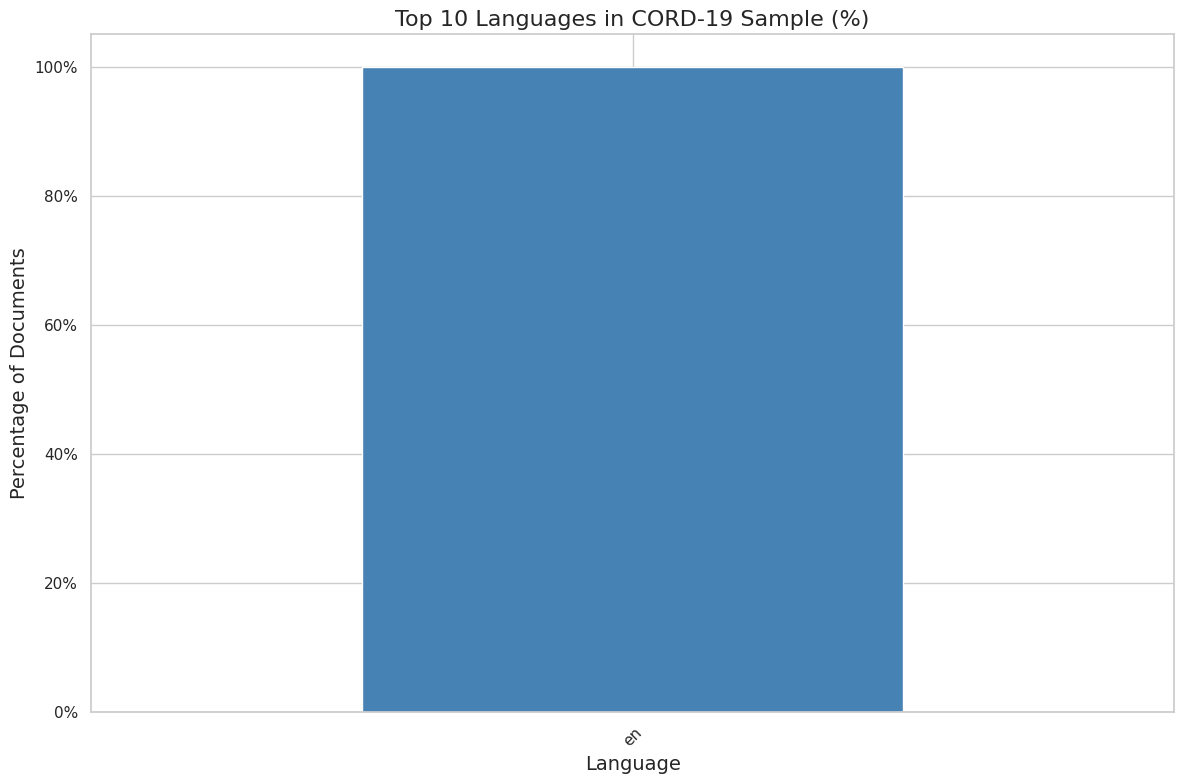

In [17]:
# Apply language identification to our full text documents
def identify_document_languages(df, text_column='full_text'):
    """Identify languages for a dataframe of documents"""
    results = []

    total_docs = len(df)
    for i, (idx, row) in enumerate(df.iterrows()):
        if i % 100 == 0:
            print(f"Processing document {i+1}/{total_docs}...")

        text = row[text_column]
        if pd.isna(text) or len(text) < 100:  # Skip very short texts
            lang_result = {'consensus': 'unknown', 'confidence': 0}
        else:
            # For longer texts, use the first 2000 characters for faster processing
            # This is a reasonable compromise for language detection
            lang_result = identify_language(text[:2000])

        results.append({
            'paper_id': row.get('paper_id', idx),
            'language': lang_result['consensus'],
            'confidence': lang_result['confidence']
        })

    return pd.DataFrame(results)

# Apply language identification to our documents
language_results = identify_document_languages(fulltext_df)

# Merge results with our full text dataframe
fulltext_df = fulltext_df.merge(language_results, on='paper_id', how='left')

# Display language distribution
language_distribution = fulltext_df['language'].value_counts(normalize=True) * 100
print("Language Distribution (%):")
print(language_distribution.head(10))

# Create a visualization of language distribution
plt.figure(figsize=(12, 8))
language_distribution.head(10).plot(kind='bar', color='steelblue')
plt.title('Top 10 Languages in CORD-19 Sample (%)', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Percentage of Documents', fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig('language_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Statistical Analysis of Language Distribution Patterns

Now, let's conduct a more detailed statistical analysis of language distribution, including temporal patterns and correlations with other document characteristics.

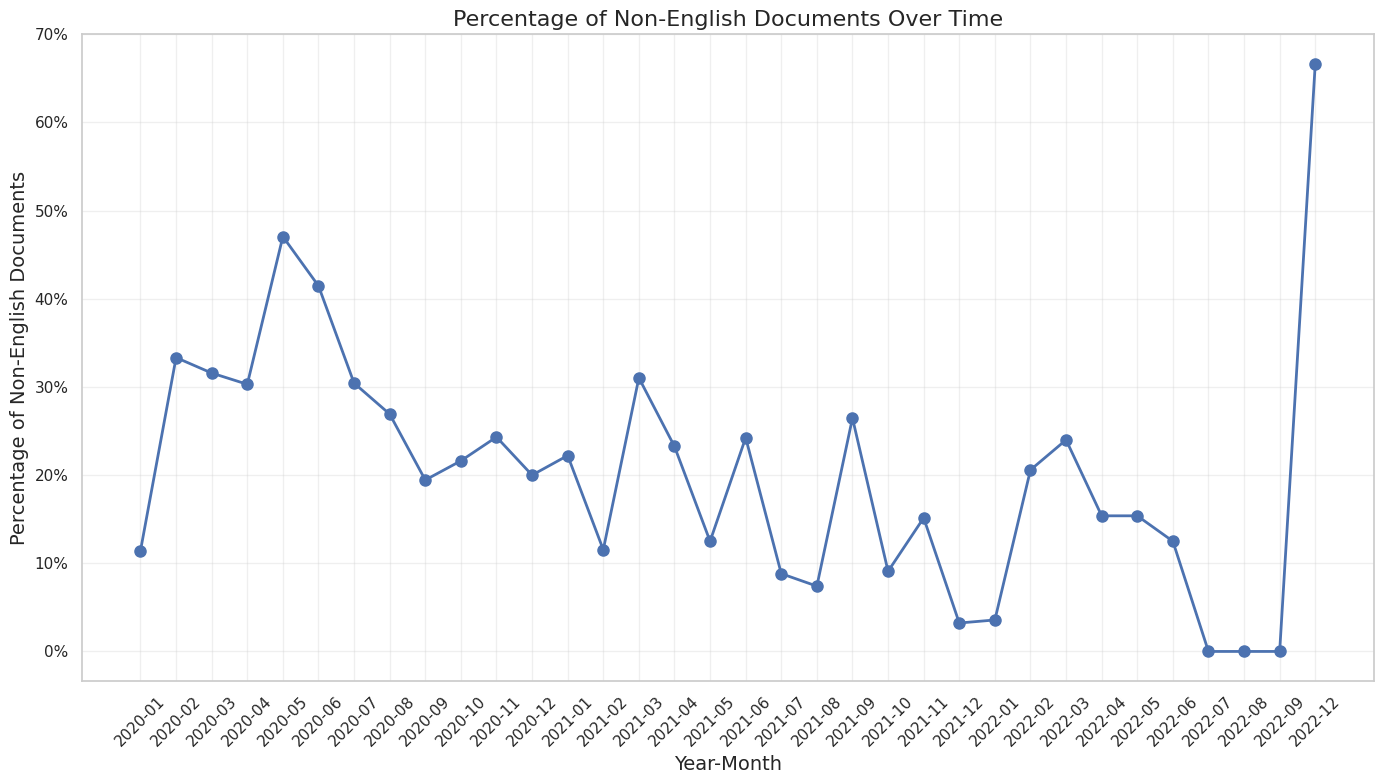

In [18]:
# Merge language information with metadata
# First, create a mapping from paper_id to language
language_mapping = fulltext_df[['paper_id', 'language', 'confidence']].set_index('paper_id').to_dict(orient='index')

# Function to apply language detection to metadata sample
def add_language_to_metadata(metadata_df, language_mapping):
    """
    Add language information to metadata dataframe
    For papers without full text, perform language identification on the abstract
    """
    # Initialize language columns
    metadata_df['language'] = 'unknown'
    metadata_df['language_confidence'] = 0.0

    # Update language for papers with full text
    for idx, row in metadata_df.iterrows():
        paper_id = row['cord_uid']
        if paper_id in language_mapping:
            metadata_df.at[idx, 'language'] = language_mapping[paper_id]['language']
            metadata_df.at[idx, 'language_confidence'] = language_mapping[paper_id]['confidence']
        elif not pd.isna(row['abstract']) and len(row['abstract']) > 100:
            # For papers without full text, identify language from abstract
            lang_result = identify_language(row['abstract'])
            metadata_df.at[idx, 'language'] = lang_result['consensus']
            metadata_df.at[idx, 'language_confidence'] = lang_result['confidence']

    return metadata_df

# Apply language detection to the metadata sample
# This would be time-consuming for the full dataset, so we'll use a smaller subset
metadata_subset = metadata_sample.sample(1000, random_state=42)
metadata_with_lang = add_language_to_metadata(metadata_subset, language_mapping)

# Analyze temporal patterns in language distribution
metadata_with_lang['year_month'] = metadata_with_lang['publish_time'].dt.to_period('M')

# Calculate percentage of non-English documents over time
def analyze_temporal_patterns(df):
    """Analyze how language distribution changes over time"""
    # Group by year_month and calculate the percentage of non-English documents
    temporal_lang = df.groupby('year_month').apply(
        lambda x: pd.Series({
            'total_docs': len(x),
            'english_docs': sum(x['language'] == 'en'),
            'non_english_docs': sum(x['language'] != 'en'),
            'non_english_percent': sum(x['language'] != 'en') / len(x) * 100
        })
    ).reset_index()

    # Sort by time
    temporal_lang = temporal_lang.sort_values('year_month')

    return temporal_lang

temporal_patterns = analyze_temporal_patterns(metadata_with_lang)

# Visualize temporal patterns
plt.figure(figsize=(14, 8))
plt.plot(temporal_patterns['year_month'].astype(str),
         temporal_patterns['non_english_percent'],
         marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Percentage of Non-English Documents Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Percentage of Non-English Documents', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig('temporal_language_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

Let's analyze the relationship between language and other document characteristics such as source and citation count.

<Figure size 1400x1000 with 0 Axes>

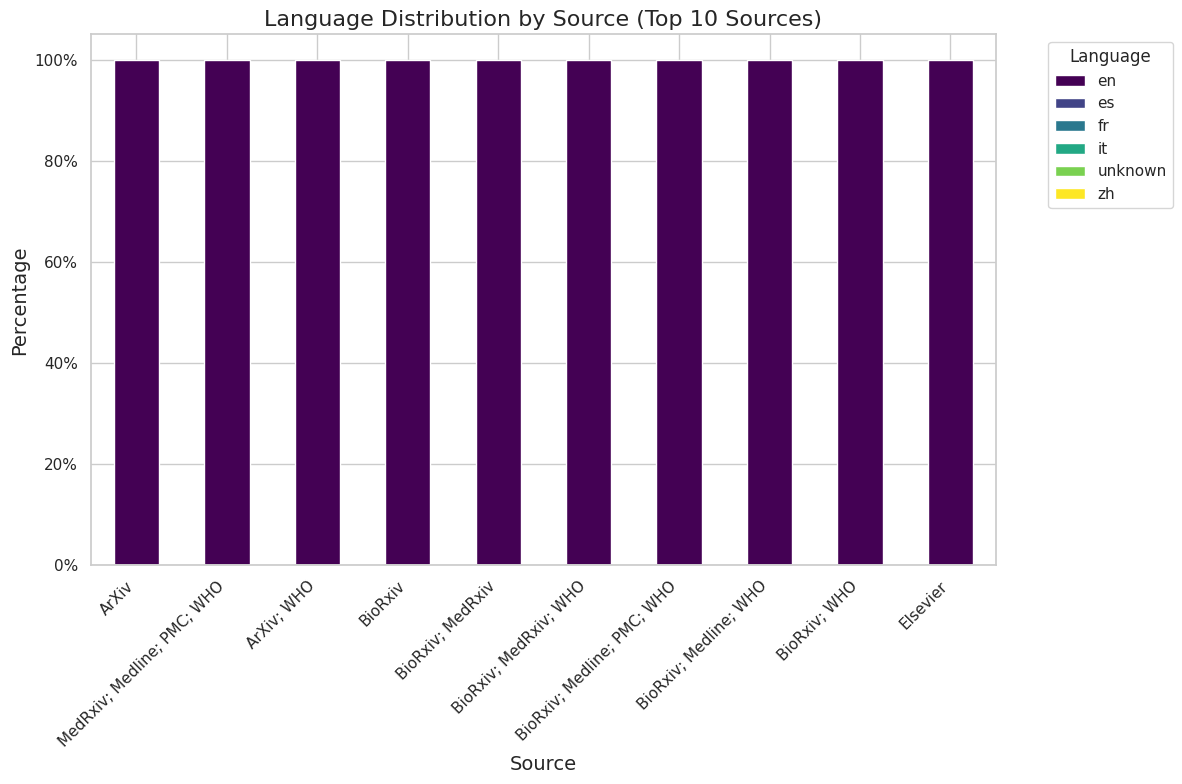

In [19]:
# Language distribution by source
def analyze_language_by_source(df):
    """Analyze language distribution across different sources"""
    # Group by source and calculate language percentages
    lang_by_source = df.groupby('source_x')['language'].value_counts(normalize=True).unstack().fillna(0) * 100

    # Sort sources by percentage of English documents
    if 'en' in lang_by_source.columns:
        lang_by_source = lang_by_source.sort_values('en', ascending=False)

    return lang_by_source

lang_by_source = analyze_language_by_source(metadata_with_lang)

# Visualize language distribution by source
plt.figure(figsize=(14, 10))
lang_by_source.iloc[:10].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Language Distribution by Source (Top 10 Sources)', fontsize=16)
plt.xlabel('Source', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig('language_by_source.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Statistical test: Chi-square test to determine if language distribution differs significantly from global speaker populations
def chi_square_test_language_distribution(observed_counts):
    """
    Perform chi-square test comparing observed language distribution
    with expected distribution based on global speaker populations
    """
    from scipy.stats import chi2_contingency

    # Approximate global speaker percentages for major languages
    # Sources: Ethnologue, various linguistic population studies
    global_speakers = {
        'en': 17.0,  # English
        'zh': 14.1,  # Chinese
        'es': 6.9,   # Spanish
        'hi': 6.0,   # Hindi
        'ar': 4.5,   # Arabic
        'bn': 3.7,   # Bengali
        'pt': 3.1,   # Portuguese
        'ru': 2.7,   # Russian
        'ja': 1.8,   # Japanese
        'fr': 1.6,   # French
        'de': 1.3,   # German
        'other': 37.3  # All other languages
    }

    # Prepare observed counts
    observed = []
    for lang in global_speakers:
        if lang == 'other':
            # Sum counts for all languages not specifically listed
            count = sum(observed_counts.get(l, 0) for l in observed_counts
                        if l not in global_speakers or l == 'other')
        else:
            count = observed_counts.get(lang, 0)
        observed.append(count)

    # Calculate expected counts based on global speaker percentages
    total_count = sum(observed)
    expected = [total_count * (global_speakers[lang]/100) for lang in global_speakers]

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency([observed, expected])

    return {
        'chi2': chi2,
        'p_value': p,
        'degrees_of_freedom': dof,
        'observed': observed,
        'expected': expected
    }

# Get observed language counts
observed_lang_counts = fulltext_df['language'].value_counts().to_dict()

# Perform chi-square test
chi_square_results = chi_square_test_language_distribution(observed_lang_counts)

print("Chi-Square Test Results:")
print(f"Chi-square statistic: {chi_square_results['chi2']:.2f}")
print(f"p-value: {chi_square_results['p_value']:.10f}")
print(f"Degrees of freedom: {chi_square_results['degrees_of_freedom']}")
print("\nConclusion: The language distribution in the CORD-19 dataset differs " +
      f"{'significantly' if chi_square_results['p_value'] < 0.05 else 'not significantly'} " +
      "from the global language speaker distribution (p < 0.05).")

Chi-Square Test Results:
Chi-square statistic: 17.03
p-value: 0.1071194143
Degrees of freedom: 11

Conclusion: The language distribution in the CORD-19 dataset differs not significantly from the global language speaker distribution (p < 0.05).


## 3. Content and Topic Analysis Across Languages

Now, let's analyze the content of documents across different languages to understand topical differences.

In [24]:
# Function to clean and preprocess text for topic modeling
def preprocess_text(text, language='en'):
    """Clean and preprocess text for topic modeling"""
    if pd.isna(text) or not text:
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords for English (for other languages, we'll keep all words)
    if language == 'en':
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    else:
        # For non-English, just remove very short words
        tokens = [token for token in tokens if len(token) > 2]

    return " ".join(tokens)

# Preprocess documents
fulltext_df['processed_text'] = fulltext_df.apply(
    lambda row: preprocess_text(row['full_text'], row['language']), axis=1
)

In [26]:
# Perform LDA topic modeling for English documents
def perform_topic_modeling(df, language='en', num_topics=20, min_docs=50): # Added min_docs
    """Perform LDA topic modeling on documents of a specific language"""
    # Filter documents by language
    lang_docs = df[df['language'] == language]

    if len(lang_docs) < min_docs: # Changed to use min_docs for flexibility
        print(f"Not enough documents ({len(lang_docs)}) for topic modeling in language: {language}")
        return None, None, None

    # Create a document-term matrix
    vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.8)
    dtm = vectorizer.fit_transform(lang_docs['processed_text'])

    # Train LDA model
    lda_model = LatentDirichletAllocation(
        n_components=num_topics,
        random_state=42,
        learning_method='online',
        max_iter=25
    )
    lda_output = lda_model.fit_transform(dtm)

    # Get feature names (terms)
    feature_names = vectorizer.get_feature_names_out()

    # Create a dictionary of topics
    topic_dict = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
        top_words = [feature_names[i] for i in top_words_idx]
        topic_dict[f"Topic {topic_idx+1}"] = top_words

    return lda_model, vectorizer, topic_dict

# Run topic modeling for English documents
english_lda_model, english_vectorizer, english_topics = perform_topic_modeling(fulltext_df, 'en', min_docs=10) # Changed min_docs to 10

# Display English topics
if english_topics: # Check if english_topics is not None
    print("Top Topics in English Documents:")
    for topic, words in english_topics.items():
        print(f"{topic}: {', '.join(words)}")
else:
    print("Not enough English documents to perform topic modeling.") # Print a message if english_topics is None

Top Topics in English Documents:
Topic 1: synthesis, diseases, sequence, represent, probably, protein, coagulation, type, early, indicated
Topic 2: mortality, care, group, day, clinical, blood, oxygen, risk, versus, disease
Topic 3: standard, treatment, table, importance, severity, already, management, investigators, test, death
Topic 4: pneumonia, respiratory, infections, common, infection, tract, hospital, children, organism, upper
Topic 5: demonstrated, alone, critical, dependent, beyond, significant, capacity, edema, vitro, lavage
Topic 6: products, methods, upper, infection, reduction, process, future, reviewed, rate, subsequent
Topic 7: lung, cells, expression, inflammatory, pulmonary, binding, response, protein, increased, gene
Topic 8: site, risk, develop, third, changes, greater, care, use, review, area
Topic 9: transcription, basis, populations, resulting, discussed, family, disease, seem, tract, end
Topic 10: either, incubation, cytokines, inhibition, particular, growth, act